# Linear Regression: Predicting Car Insurance Claim Amounts
## Model Performance Evaluation

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import norm
import math
%matplotlib inline
pd.options.display.max_rows = 40
import warnings

import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso,Ridge

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from skimpy import clean_columns
from nltk.metrics import edit_distance

warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
class Cleaner:
    def __init__(self, df):

        self.cdf = clean_columns(df,case='snake')
        self.numerics_df =  self.cdf.select_dtypes(include=[np.number])
        self.numeric_cols = self.numerics_df.columns.values
        self.cats_df =   self.cdf.select_dtypes(include=object)
        self.cat_cols = self.cats_df.columns.values

    def drop_dups(self):
        df = self.cdf
        df_dedupped = df.drop_duplicates()
        # there were duplicate rows
        print('Dropping {} duplicates'.format(df.shape[0] - df_dedupped.shape[0]))
        df = df_dedupped

    def drop_select_dups(self, keys):
        #df.fillna(-999).groupby(keys)['id'].count().sort_values(ascending=False).head(20)
        self.cdf = self.cdf.drop_duplicates(subset=keys)

    def show_missing(self):
        for col in self.cdf.columns:
            pct_missing = np.mean(self.cdf[col].isnull())
            print('{} - {}%'.format(col, round(pct_missing*100)))

    def drop_missing(self, replace=False):
        df = self.cdf
        # first create missing indicator for features with missing data
        for col in df.columns:
            missing = df[col].isnull()
            num_missing = np.sum(missing)
            if num_missing > 0:
                print('created missing indicator for: {}'.format(col))
                df['{}_ismissing'.format(col)] = missing

            if replace == True:
                # categorical
                if col in set(self.numeric_cols):
                    print('Numerical column '+col+' has missing values.')
                    filler = input('Input a filler value (e.g. -999).')
                    df[col] = df[col].fillna(filler).astype(int)
                else:
                    print('Categorical column '+col+' has missing values.')
                    filler = input('Input a filler value (e.g. _MISSING_). ')
                    df[col] = df[col].fillna(filler)

        if replace == False:
            from math import ceil
            cut_off = ceil(0.50*len(df.columns)) # if a row is missing more than 10% of its entries drop it
            ismissing_cols = [col for col in df.columns if 'ismissing' in col]
            df['num_missing'] = df[ismissing_cols].sum(axis=1)
            # drop rows with a lot of missing values.
            ind_missing = df[df['num_missing'] > cut_off].index
            df = df.drop(ind_missing, axis=0)

    def impute_numerics(self):
        df = self.cdf
        for col in self.numeric_cols:
            missing = df[col].isnull()
            num_missing = np.sum(missing)

            if num_missing > 0:  # only do the imputation for the columns that have missing values.
                print('imputing missing values for: {}'.format(col))
                #df['{}_ismissing'.format(col)] = missing
                med = df[col].median()
                df[col] = df[col].fillna(med)

    def impute_cats(self):
        df = self.cdf
        for col in self.cat_cols:
            missing = df[col].isnull()
            num_missing = np.sum(missing)

            if num_missing > 0:  # only do the imputation for the columns that have missing values.
                print('imputing missing values for: {}'.format(col))
                #df['{}_ismissing'.format(col)] = missing
                top = df[col].describe()['top'] # impute with the most frequent value.
                df[col] = df[col].fillna(top)

    def redundants(self):
        df = self.cdf
        num_rows = len(df.index)
        low_information_cols = [] #

        for col in df.columns:
            cnts = df[col].value_counts(dropna=False)
            top_pct = (cnts/num_rows).iloc[0]

            if top_pct > 0.95:
                low_information_cols.append(col)
                print('{0}: {1:.5f}%'.format(col, top_pct*100))
                print(cnts)
                print()


    def col_rename(self, dict_rules):
        ''' rename columns in data frame using a dictionary of rules  '''
        if isinstance(dict_rules,dict):
            self.cdf.rename(columns = dict_rules, inplace=True)
        else:
            raise TypeError

    def expand_timestamp(self, time_colname):
        df = self.cdf
        df['timestamp_dt'] = pd.to_datetime(df[time_colname], format='%Y-%m-%d')
        df['year'] = df['timestamp_dt'].dt.year
        df['month'] = df['timestamp_dt'].dt.month
        df['weekday'] = df['timestamp_dt'].dt.weekday

        print(df['year'].value_counts(dropna=False))
        print()
        print(df['month'].value_counts(dropna=False))

    def get_typos(self,colname, word):
        tmp = pd.DataFrame([])
        tmp[colname] = self.cdf[colname]
        cn = 'distance_'+word
        tmp[cn] = self.cdf[colname].map(lambda x: edit_distance(x, word))
        return tmp.value_counts()

    def fix_typos(self,colname, word, dist=2):
        tmp = self.cdf.copy()
        tmp[colname] = self.cdf[colname]
        cn = 'distance_'+word
        tmp[cn] = self.cdf[colname].map(lambda x: edit_distance(x, word))
        msk = tmp[cn] <= dist
        self.cdf.loc[msk, colname] = word

    def row_string_replace(self, colname, replacement_dict):
        self.cdf[colname] = self.cdf[colname].replace(replacement_dict)



### Read and clean the data

In [40]:
c_df = pd.read_csv('../Data/Data_Marketing_Customer_Analysis_Round3.csv') # precleaned data

In [41]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Unnamed: 0                     10689 non-null  int64 
 1   region                         10689 non-null  object
 2   customer_lifetime_value        10689 non-null  int64 
 3   response                       10689 non-null  object
 4   coverage                       10689 non-null  object
 5   education                      10689 non-null  object
 6   effective_to_date              10689 non-null  object
 7   month                          10689 non-null  object
 8   employment_status              10689 non-null  object
 9   gender                         10689 non-null  object
 10  income                         10689 non-null  int64 
 11  location_code                  10689 non-null  object
 12  marital_status                 10689 non-null  object
 13  m

In [42]:
c_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True) # drop the unnamed field

In [43]:
numerics_df   = c_df.select_dtypes(include=np.number) # get numerical columns using the select_dtypes method
cats_df       = c_df.select_dtypes(include=object)    # get non-numeric columns

Remove outliers

In [44]:
len(numerics_df.columns)

8

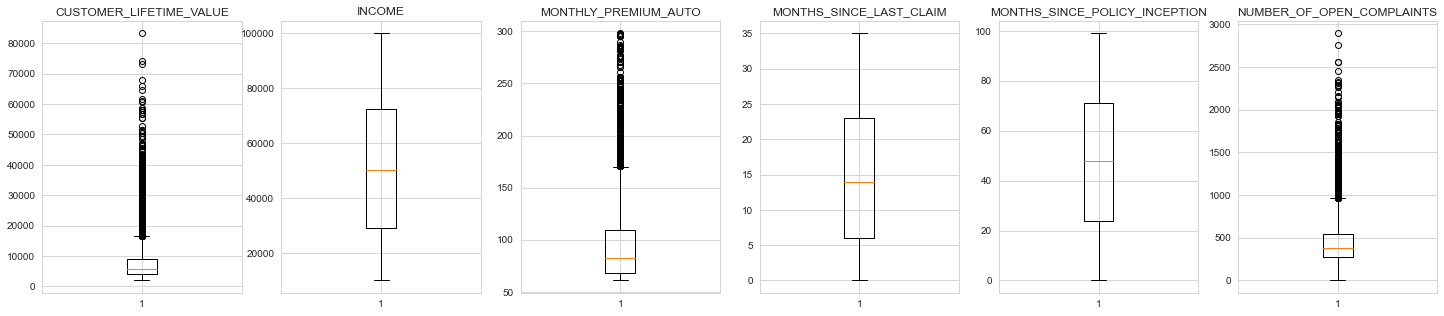

In [45]:
fig, ax = plt.subplots(1,6, figsize = (25,5))

for i in range(1,7):
    plt.subplot(1,6,i)
    plt.boxplot(numerics_df.drop(['number_of_open_complaints','number_of_policies'],axis=1).iloc[:,i-1])
    plt.title(f'{numerics_df.columns[i-1].upper()}')

In [46]:
def outlier_mask(df):
    """ returns a df of boolean values to used to index a trimmed table in the 1.5*IQR range"""
    q1 = df.quantile(0.05)
    q3 = df.quantile(0.95)
    iqr = q3 - q1
    return  ~((df < (q1 -  1.5*iqr)) |(df > (q3 + 1.5*iqr)))

In [47]:
cols_to_trim = list(numerics_df.drop(['monthly_premium_auto'],axis=1).columns)
cols_to_trim

['customer_lifetime_value',
 'income',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies',
 'total_claim_amount']

In [48]:
# boolean index list of "inliers"
inliers = outlier_mask(numerics_df[cols_to_trim]).all(1)
# select subset of the data
numerics_df = numerics_df[inliers]

In [49]:
c_df = pd.concat([cats_df, numerics_df],axis=1)

In [50]:
clnr = Cleaner(c_df)

0 column names have been cleaned

In [51]:
clnr.impute_numerics()

imputing missing values for: customer_lifetime_value
imputing missing values for: income
imputing missing values for: monthly_premium_auto
imputing missing values for: months_since_last_claim
imputing missing values for: months_since_policy_inception
imputing missing values for: number_of_open_complaints
imputing missing values for: number_of_policies
imputing missing values for: total_claim_amount


In [52]:
c_df = clnr.cdf

In [53]:
X = c_df.drop(['monthly_premium_auto'],axis=1)
y = c_df['monthly_premium_auto']

In [54]:
y.shape

(10689,)

In [55]:
c_df.isnull().sum()

region                           0
response                         0
coverage                         0
education                        0
effective_to_date                0
month                            0
employment_status                0
gender                           0
location_code                    0
marital_status                   0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
vehicle_class                    0
vehicle_size                     0
customer_lifetime_value          0
income                           0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
total_claim_amount               0
dtype: int64

In [56]:
X.drop(['effective_to_date'],axis=1,inplace=True)

In [57]:
TEST_SIZE = 0.30
RANDOM_STATE = 32 # reproduce the same results. disables randomization

## Linear Regression Model

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,random_state=RANDOM_STATE)

In [82]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3207 entries, 6003 to 7247
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   region                         3207 non-null   object 
 1   response                       3207 non-null   object 
 2   coverage                       3207 non-null   object 
 3   education                      3207 non-null   object 
 4   month                          3207 non-null   object 
 5   employment_status              3207 non-null   object 
 6   gender                         3207 non-null   object 
 7   location_code                  3207 non-null   object 
 8   marital_status                 3207 non-null   object 
 9   policy_type                    3207 non-null   object 
 10  policy                         3207 non-null   object 
 11  renew_offer_type               3207 non-null   object 
 12  sales_channel                  3207 non-null 

In [83]:
cols_to_hot_encode = ['gender', 'marital_status', 'month', 'response', 'region', 'vehicle_class', 'renew_offer_type', 'policy_type', 'policy', 'location_code', 'sales_channel', 'coverage', 'education', 'employment_status', 'vehicle_size','vehicle_size']


In [84]:
col_to_standardize = ['customer_lifetime_value','income','total_claim_amount']

In [85]:
transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_to_standardize),
    ('encode', OneHotEncoder(), cols_to_hot_encode)
], remainder = 'passthrough', verbose_feature_names_out=True)

transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['customer_lifetime_value', 'income',
                                  'total_claim_amount']),
                                ('encode', OneHotEncoder(),
                                 ['gender', 'marital_status', 'month',
                                  'response', 'region', 'vehicle_class',
                                  'renew_offer_type', 'policy_type', 'policy',
                                  'location_code', 'sales_channel', 'coverage',
                                  'education', 'employment_status',
                                  'vehicle_size', 'vehicle_size'])])

In [86]:
transformer.get_feature_names_out()

array(['standardize__customer_lifetime_value', 'standardize__income',
       'standardize__total_claim_amount', 'encode__gender_f',
       'encode__gender_m', 'encode__marital_status_divorced',
       'encode__marital_status_married', 'encode__marital_status_single',
       'encode__month_feb', 'encode__month_jan', 'encode__response_no',
       'encode__response_yes', 'encode__region_central',
       'encode__region_east', 'encode__region_north west',
       'encode__region_west region',
       'encode__vehicle_class_four-door car',
       'encode__vehicle_class_luxury car',
       'encode__vehicle_class_luxury suv',
       'encode__vehicle_class_sports car', 'encode__vehicle_class_suv',
       'encode__vehicle_class_two-door car',
       'encode__renew_offer_type_offer1',
       'encode__renew_offer_type_offer2',
       'encode__renew_offer_type_offer3',
       'encode__renew_offer_type_offer4',
       'encode__policy_type_corporate auto',
       'encode__policy_type_personal auto',
 

In [87]:
# std. transformed and encoded variables (np arrays)
X_train_e = transformer.transform(X_train)
X_test_e  = transformer.transform(X_test)

In [88]:
X_train_e_df = pd.DataFrame(X_train_e,columns=transformer.get_feature_names_out())
X_test_e_df = pd.DataFrame(X_test_e,columns=transformer.get_feature_names_out())

In [66]:
model = LinearRegression()           # model
model.fit(X_train_e, y_train)   # model train
y_pred       = model.predict(X_test_e)   # model prediction [test]
y_pred_train = model.predict(X_train_e)  # model prediction [train]
result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

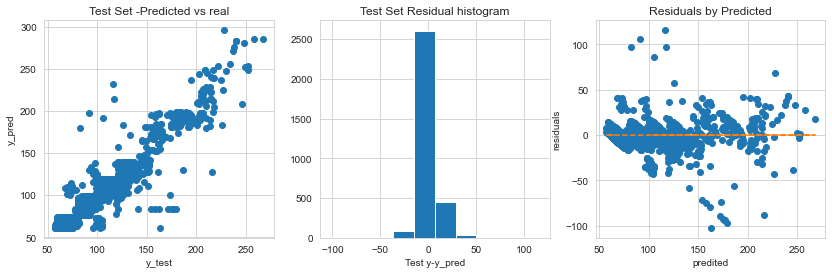

In [67]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

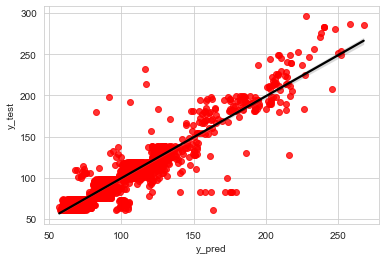

In [68]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [69]:
r2_score(y_test,y_pred)

0.8913744420967546

In [70]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_e_df.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

features_importances

,Attribute,Importance
39,encode__location_code_suburban,3.514057e+11
40,encode__location_code_urban,3.514057e+11
38,encode__location_code_rural,3.514057e+11
45,encode__coverage_basic,1.911539e+11
46,encode__coverage_extended,1.911539e+11
...,...,...
66,remainder__number_of_open_complaints,3.801270e-01
1,standardize__income,5.466672e-02
67,remainder__number_of_policies,3.244019e-02
64,remainder__months_since_last_claim,1.065063e-02


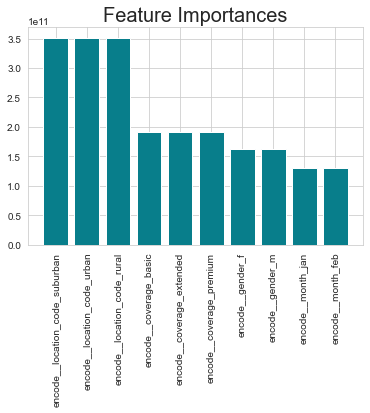

In [71]:
plt.bar(x=features_importances['Attribute'].head(10), height=features_importances['Importance'].head(10), color='#087E8B')
plt.title('Feature Importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [95]:
X_train_const_scaled = sm.add_constant(X_train_e)  #adding a constant
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled)

X_test_const_scaled = sm.add_constant(X_test_e)  #adding a constant
predictions_test = model.predict(X_test_const_scaled)
print_model = model.summary()
print(print_model)

                             OLS Regression Results                             
Dep. Variable:     monthly_premium_auto   R-squared:                       0.888
Model:                              OLS   Adj. R-squared:                  0.887
Method:                   Least Squares   F-statistic:                     1228.
Date:                  Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                          11:54:41   Log-Likelihood:                -28775.
No. Observations:                  7482   AIC:                         5.765e+04
Df Residuals:                      7433   BIC:                         5.799e+04
Df Model:                            48                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0442      0.111

In [73]:
print_model.tables[0]

Dep. Variable:,monthly_premium_auto,R-squared:,0.888
Model:,OLS,Adj. R-squared:,0.887
Method:,Least Squares,F-statistic:,1228.
Date:,"Thu, 17 Nov 2022",Prob (F-statistic):,0.00
Time:,11:43:44,Log-Likelihood:,-28775.
No. Observations:,7482,AIC:,5.765e+04
Df Residuals:,7433,BIC:,5.799e+04
Df Model:,48,,
Covariance Type:,nonrobust,,


In [74]:
model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[0:].index.tolist()
significant_features=X_train_e_df[model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[0:].index.tolist()]
sigcols=significant_features.columns
sigcols

KeyError: "None of [Index(['const', 'x1', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',\n       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',\n       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',\n       'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42',\n       'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52',\n       'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62',\n       'x63', 'x64', 'x67'],\n      dtype='object')] are in the [columns]"

In [ ]:
import xgboost as xgb

In [ ]:
xgb_r = xgb.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = RANDOM_STATE)

In [ ]:
# Fitting the model
xgb_r.fit(X_train_e,y_train)

# Predict the model
pred = xgb_r.predict(X_test_e)

In [ ]:
# R2 Computation
r2 = r2_score(y_test,pred)
print("R2 score : % f" %(r2))

In [ ]:
model=Lasso(alpha=0.05)

model.fit(X_train_e, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train_e, y_train)}, Test -> {model.score(X_test_e, y_test)}")

In [ ]:
model=Ridge(alpha=0.05)
model.fit(X_train_e, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train_e, y_train)}, Test -> {model.score(X_test_e, y_test)}")